In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 14})

# Statistical tests
from scipy.stats import kruskal
from scipy.stats import shapiro
from scipy.stats import spearmanr
from scipy.stats import levene
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

# Assessing the clinical relevance of the model

## Loading the data

The data provided by Dr. Peter Hellyer exists of both demographic data and FA data. The FA data should be transformed into structural connectomes. For this purpose, we use the template matrix C (Hellyer <i>et al.</i>, 2015).

In [2]:
demo = pd.read_excel("data/human/101_Demographics.xlsx", sheet_name="Sheet1")

C:\Users\laura\anaconda3\envs\test2\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


### Determining the reference group

The reference group is determined based on age-matching of the reference group, the control group and the patient group.

In [3]:
patient_ids = [1, 2, 3, 12, 13, 18, 25, 26, 28] # Choice of controls

reference = demo.Age[demo["WM ID"].isin(patient_ids)]
control = demo.Age[~(demo["WM ID"].isin(patient_ids)) & (demo.GRP == "CON")]
patients = demo.Age[demo.GRP == "PAT"]

In [4]:
# Shapiro-Wilk test for normality
# Null-hypothesis: samples are drawn from a normal distribution

print("reference: ", shapiro(reference))
print("control: ", shapiro(control))
print("patients: ", shapiro(patients))

reference:  ShapiroResult(statistic=0.834951639175415, pvalue=0.050734635442495346)
control:  ShapiroResult(statistic=0.93438720703125, pvalue=0.1360369473695755)
patients:  ShapiroResult(statistic=0.9619938135147095, pvalue=0.04629093408584595)


This result shows that the age of the patient group is most likely not drawn from a normal distribution.

In [5]:
# Kruskal-Wallis H-test
# Null-hypothesis: the population median of all of the groups are equal.

print(kruskal(reference, control, patients))

KruskalResult(statistic=5.6462214752263105, pvalue=0.05942081235625017)


There is no evidence to reject the null-hypothesis. So, the medians of the groups are equal.

### Building the structural connectivity matrices

The reference group is used to calculate the z-scores of the FA matrices.

In [6]:
references = []
for i in patient_ids:
    file = f"data/human/FA_MEAN_{i}.csv"
    w = np.loadtxt(file, delimiter=",")

    # Remove the brainstem
    w_reduced = np.delete(w, 148, axis=0)
    w = np.delete(w_reduced, 148, axis=1)

    references.append(w)
references = np.array(references)

In [7]:
# Calculate the mean and standard deviation
w_mean = np.mean(references, axis=0)
w_std = np.std(references, axis=0)

We need to load the template of the structural connectivity matrices.

In [8]:
C = np.loadtxt(f"data/human/C.csv", delimiter=",")

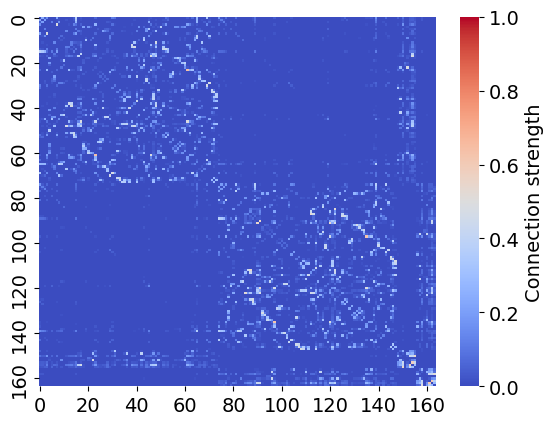

In [9]:
# Visualisation

sns.heatmap(C, cmap = "coolwarm", vmin=0, vmax=1, xticklabels=20, yticklabels=20, cbar_kws={'label': 'Connection strength'})
plt.show()

This C template is adapted according to the z-score. When a z-score is < -1.6, then the connection strength of the C template is halved.

In [10]:
for i in demo["WM ID"][~demo["WM ID"].isin(patient_ids)].values:
    # Calculate the z-scores
    file = f"data/human/FA_MEAN_{i}.csv"
    w = np.loadtxt(file, delimiter=",")
    w_reduced = np.delete(w, 148, axis=0)
    w = np.delete(w_reduced, 148, axis=1)
    z_score = (w - w_mean) / (w_std + 0.00001) # To avoid NaN values

    # Adjust the template
    Ci = C.copy()
    Ci[z_score < -1.6] *= 0.5

    # Save the structural connectome
    np.save(f"data/human/C_{i}.npy", Ci)

We can easily visualise the structural connectomes in a heatmap.

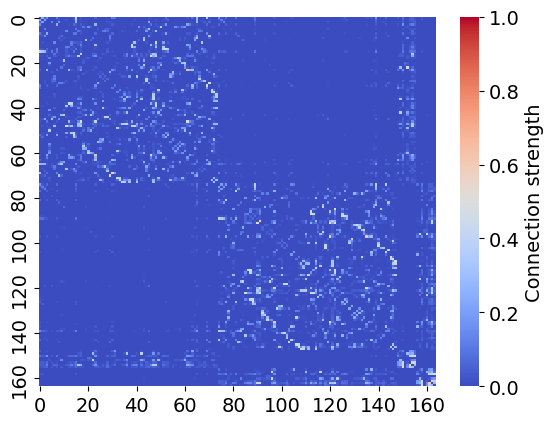

In [11]:
w = np.load("data/human/C_42.npy")

sns.heatmap(w, cmap = "coolwarm", vmin=0, vmax=1, xticklabels=20, yticklabels=20, cbar_kws={'label': 'Connection strength'})
plt.show()

## Validation: how many connections were lesioned?

In [12]:
l = []
for i in demo["WM ID"][~demo["WM ID"].isin(patient_ids)].values:
    # Calculate the z-scores
    file = f"data/human/FA_MEAN_{i}.csv"
    w = np.loadtxt(file, delimiter=",")
    w_reduced = np.delete(w, 148, axis=0)
    w = np.delete(w_reduced, 148, axis=1)
    z_score = (w - w_mean) / (w_std + 0.00001) # To avoid NaN values
    Ci = C.copy()
    
    d = {"id": i, "n_lesions": np.sum((z_score < -1.6)&(Ci != 0))}
    l.append(d)

df = pd.DataFrame.from_dict(l)

In [13]:
full_info = pd.merge(df, demo, left_on="id", right_on="WM ID", how="left")

Visualise the spread of the lesions in the controls and the patients.

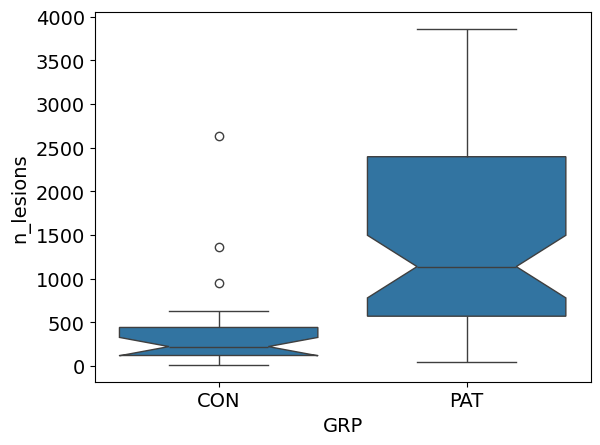

In [14]:
sns.boxplot(data=full_info, x = "GRP", y = "n_lesions", notch=True)
plt.show()

In [15]:
controls_lesions = full_info[full_info.GRP == "CON"].n_lesions.values
patients_lesions = full_info[full_info.GRP == "PAT"].n_lesions.values

In [16]:
levene(controls_lesions, patients_lesions)

LeveneResult(statistic=18.014255335342888, pvalue=5.5683152553010814e-05)

In [17]:
ttest_ind(controls_lesions, patients_lesions, equal_var=False) # Welch's ttest

Ttest_indResult(statistic=-5.761970371519326, pvalue=1.9787820542499039e-07)

There is some overlap in the number of lesions between controls and patients. With some outliers in the control group. However, the groups have significantly different medians. Here, the patients have more lesions.

## Estimated Memory Capacity using reservoir models

### Without delays

The memory capacity of each individual structural connectome is estimated using a model with or without plasticity. These experiments are run using the HPC and loaded into excel files. The code to create these files can be found in "clinical_lesions.py".

In [18]:
no_plasticity = pd.read_csv("objective3/df_thalamic_165.csv")
plasticity = pd.read_csv("objective3/df_thalamic_165_plasticity.csv")

In [19]:
# Add the type of model
no_plasticity["Type"] = "No plasticity"
plasticity["Type"] = "Plasticity"

In [20]:
# Combine the dataframes
combined = pd.concat([no_plasticity, plasticity], ignore_index=True)

In [21]:
# Add additional information
full_info = pd.merge(combined, demo, left_on="identifier", right_on="WM ID", how="left")

Visualise the memory capacity of both groups

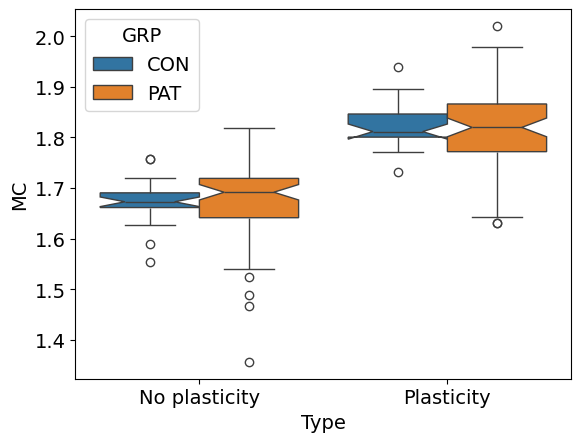

In [22]:
sns.boxplot(data=full_info, x="Type", y="MC", hue="GRP", notch=True)
plt.show()

### Statistical testing

In [23]:
# Shaprio-Wilk test for normality
print("No plasticity - controls: ", shapiro(full_info.MC[(full_info.Type == "No plasticity") & (full_info.GRP == "CON")]))

No plasticity - controls:  ShapiroResult(statistic=0.9033777117729187, pvalue=0.029692772775888443)


In [24]:
# Mann-Whitney U test for equal distributions
print("No plasticity: ", mannwhitneyu(full_info.MC[(full_info.Type == "No plasticity") & (full_info.GRP == "CON")], full_info.MC[(full_info.Type == "No plasticity") & (full_info.GRP == "PAT")]))
print("No plasticity: ", mannwhitneyu(full_info.MC[(full_info.Type == "Plasticity") & (full_info.GRP == "CON")], full_info.MC[(full_info.Type == "Plasticity") & (full_info.GRP == "PAT")]))

No plasticity:  MannwhitneyuResult(statistic=614.0, pvalue=0.24223321656311103)
No plasticity:  MannwhitneyuResult(statistic=734.0, pvalue=0.988481083885465)


The null hypothesis is rejected - and a non-parametrical test is conducted.

The most striking part is that the MC is estimated lower for the controls while their number of lesions is significantly lower than that of the patients.

The overall spread of the data is higher for the patients.

### With delays

Again, the experiments were run on the HPC and loaded into csv files.

In [25]:
no_plasticity = pd.read_csv("objective3/df_thalamic_165_delay.csv")
plasticity = pd.read_csv("objective3/df_thalamic_165_plasticity_delay.csv")

In [26]:
# Add the type of model
no_plasticity["Type"] = "No plasticity"
plasticity["Type"] = "Plasticity"

In [27]:
# Combine the dataframes
combined = pd.concat([no_plasticity, plasticity], ignore_index=True)

In [28]:
# Add additional information
full_info = pd.merge(combined, demo, left_on="identifier", right_on="WM ID", how="left")

The first thing that is noticable is the higher MC when delays are added into the network.

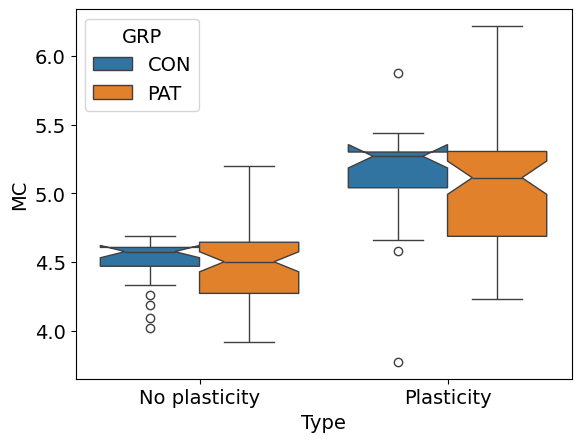

In [29]:
sns.boxplot(data=full_info, x="Type", y="MC", hue="GRP", notch=True)
plt.show()

In [30]:
# Mann-Whitney U test for equal distributions
print("No plasticity: ", mannwhitneyu(full_info.MC[(full_info.Type == "No plasticity") & (full_info.GRP == "CON")], full_info.MC[(full_info.Type == "No plasticity") & (full_info.GRP == "PAT")]))
print("No plasticity: ", mannwhitneyu(full_info.MC[(full_info.Type == "Plasticity") & (full_info.GRP == "CON")], full_info.MC[(full_info.Type == "Plasticity") & (full_info.GRP == "PAT")]))

No plasticity:  MannwhitneyuResult(statistic=792.0, pvalue=0.593216374182536)
No plasticity:  MannwhitneyuResult(statistic=854.0, pvalue=0.2580872693925731)


Now that delays are added into the network, the controls are outperforming the patients. However, this result is not significant, hence the overlapping notches.

The spread on the patient data remain large. Some outliers also exist for the patients. These could correspond to the outliers that were noticable when the number of lesions was assessed.

## Clinical data

The patients also did clinical tests:
- Choice Reaction Time
- Executive Function
- Associative Memory

In the plots below, we assess whether the results of these tests align with the results obtained by the model.

Based on the nature of the clinical tests, we expect at least a monotonic relationship between the clinical test and the model MC. A linear relationship is not guaranteed.

In [31]:
model = pd.read_csv("objective3/df_thalamic_165.csv")
plasticity = pd.read_csv("objective3/df_thalamic_165_plasticity.csv")
delay = pd.read_csv("objective3/df_thalamic_165_delay.csv")
delay_plasticity = pd.read_csv("objective3/df_thalamic_165_plasticity_delay.csv")

In [32]:
# Add the type of model
model["Type"] = "General model"
plasticity["Type"] = "Plasticity"
delay["Type"] = "Delay"
delay_plasticity["Type"] = "Delay & Plasticity"

In [33]:
# Combine the dataframes
combined = pd.concat([model, plasticity, delay, delay_plasticity], ignore_index=True)

In [34]:
# Add additional information
full_info = pd.merge(combined, demo, left_on="identifier", right_on="WM ID", how="left")

### Choice reaction time

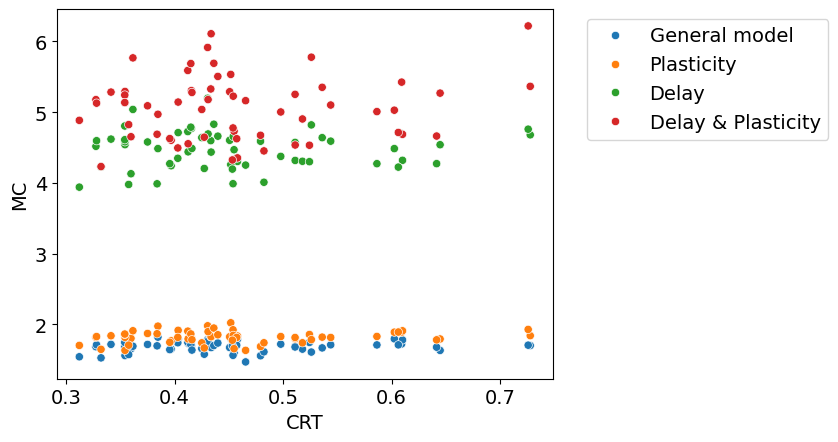

In [35]:
sns.scatterplot(data=full_info[full_info.CRT != 0], x="CRT", y="MC", hue="Type")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

Can we use Pearson correlation? Check for normality.

In [36]:
print(shapiro(full_info[(full_info.CRT != 0) & (full_info.Type == "General model")].CRT))

ShapiroResult(statistic=0.924504816532135, pvalue=0.0011700440663844347)


The null-hypothesis that the variable is normally distributed is rejected. So, we should use the Spearman correlation coefficient.

In [37]:
print("General model: ", spearmanr(full_info[(full_info.CRT != 0) & (full_info.Type == "General model")].CRT, full_info[(full_info.CRT != 0) & (full_info.Type == "General model")].MC))
print("Plasticity model: ", spearmanr(full_info[(full_info.CRT != 0) & (full_info.Type == "Plasticity")].CRT, full_info[(full_info.CRT != 0) & (full_info.Type == "Plasticity")].MC))
print("Delay model: ", spearmanr(full_info[(full_info.CRT != 0) & (full_info.Type == "Delay")].CRT, full_info[(full_info.CRT != 0) & (full_info.Type == "Delay")].MC))
print("Delay & Plasticity model: ", spearmanr(full_info[(full_info.CRT != 0) & (full_info.Type == "Delay & Plasticity")].CRT, full_info[(full_info.CRT != 0) & (full_info.Type == "Delay & Plasticity")].MC))

General model:  SignificanceResult(statistic=0.08974964575972948, pvalue=0.4952694533373351)
Plasticity model:  SignificanceResult(statistic=0.08472033124502018, pvalue=0.5198382096547758)
Delay model:  SignificanceResult(statistic=-0.0004723665566301551, pvalue=0.9971420118107852)
Delay & Plasticity model:  SignificanceResult(statistic=0.033371307912518605, pvalue=0.8001709621663549)


None of the values are significant. So, there is no proof of a monotonic relationship between the CRT and the MC.

### Executive Function

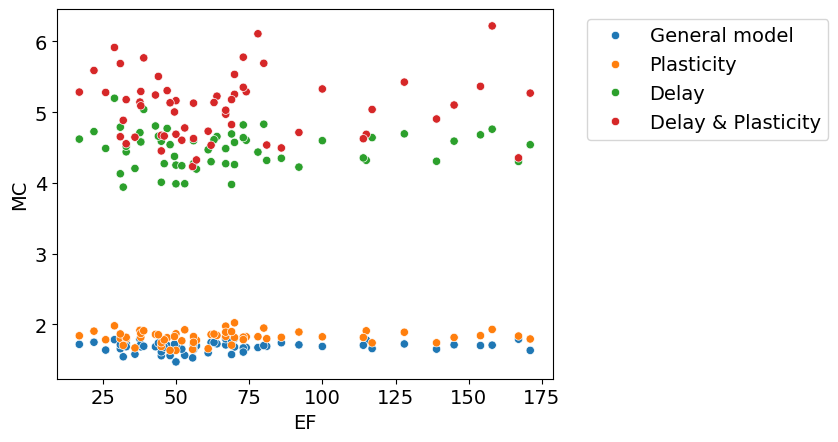

In [38]:
sns.scatterplot(data=full_info[full_info.EF != 0], x="EF", y="MC", hue="Type")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [39]:
print("General model: ", spearmanr(full_info[(full_info.EF != 0) & (full_info.Type == "General model")].EF, full_info[(full_info.EF != 0) & (full_info.Type == "General model")].MC))
print("Plasticity model: ", spearmanr(full_info[(full_info.EF != 0) & (full_info.Type == "Plasticity")].EF, full_info[(full_info.EF != 0) & (full_info.Type == "Plasticity")].MC))
print("Delay model: ", spearmanr(full_info[(full_info.EF != 0) & (full_info.Type == "Delay")].EF, full_info[(full_info.EF != 0) & (full_info.Type == "Delay")].MC))
print("Delay & Plasticity model: ", spearmanr(full_info[(full_info.EF != 0) & (full_info.Type == "Delay & Plasticity")].EF, full_info[(full_info.EF != 0) & (full_info.Type == "Delay & Plasticity")].MC))

General model:  SignificanceResult(statistic=0.09043033760166069, pvalue=0.4919912588658868)
Plasticity model:  SignificanceResult(statistic=0.06917059320544974, pvalue=0.5994776321799398)
Delay model:  SignificanceResult(statistic=-0.0043631109414446, pvalue=0.9736062384241086)
Delay & Plasticity model:  SignificanceResult(statistic=-0.008754012398439802, pvalue=0.9470728136936117)


### Associative Memory

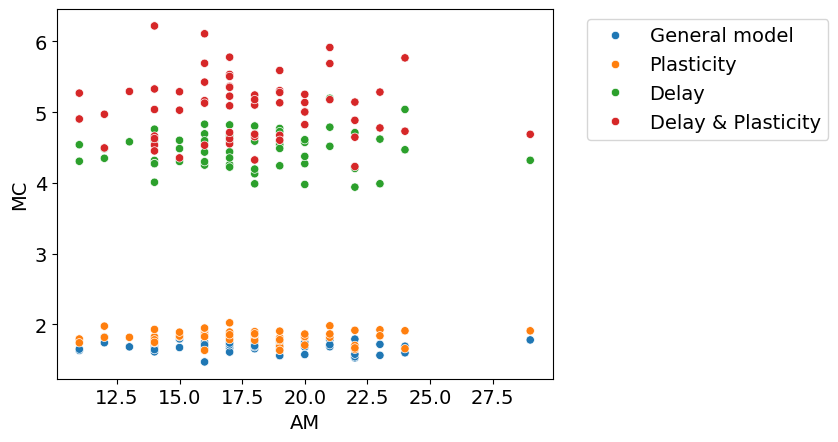

In [40]:
sns.scatterplot(data=full_info[full_info.EF != 0], x="AM", y="MC", hue="Type")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [41]:
print("General model: ", spearmanr(full_info[(full_info.AM != 0) & (full_info.Type == "General model")].AM, full_info[(full_info.AM != 0) & (full_info.Type == "General model")].MC))
print("Plasticity model: ", spearmanr(full_info[(full_info.AM != 0) & (full_info.Type == "Plasticity")].AM, full_info[(full_info.AM != 0) & (full_info.Type == "Plasticity")].MC))
print("Delay model: ", spearmanr(full_info[(full_info.AM != 0) & (full_info.Type == "Delay")].AM, full_info[(full_info.AM != 0) & (full_info.Type == "Delay")].MC))
print("Delay & Plasticity model: ", spearmanr(full_info[(full_info.AM != 0) & (full_info.Type == "Delay & Plasticity")].AM, full_info[(full_info.AM != 0) & (full_info.Type == "Delay & Plasticity")].MC))

General model:  SignificanceResult(statistic=-0.07255862994371443, pvalue=0.5816742828110408)
Plasticity model:  SignificanceResult(statistic=0.045048910738726466, pvalue=0.7325160914588068)
Delay model:  SignificanceResult(statistic=0.007038019532646664, pvalue=0.9574370311508378)
Delay & Plasticity model:  SignificanceResult(statistic=0.027733148396500543, pvalue=0.8334011496039078)


# References

[1] Falandays, J.B., Yoshimi, J., Warren, W.H. et al. A potential mechanism for Gibsonian resonance: behavioral entrainment emerges from local homeostasis in an unsupervised reservoir network. Cogn Neurodyn 18, 1811–1834 (2024). https://doi.org/10.1007/s11571-023-09988-2

[2] Iacob S, Dambre J. Exploiting Signal Propagation Delays to Match Task Memory Requirements in Reservoir Computing. Biomimetics (Basel). 2024 Jun 14;9(6):355. doi: 10.3390/biomimetics9060355. PMID: 38921237; PMCID: PMC11201534.

[3] Suárez, L.E., Mihalik, A., Milisav, F. et al. Connectome-based reservoir computing with the conn2res toolbox. Nat Commun 15, 656 (2024). https://doi.org/10.1038/s41467-024-44900-4

[4] Hellyer PJ, Scott G, Shanahan M, Sharp DJ, Leech R. Cognitive Flexibility through Metastable Neural Dynamics Is Disrupted by Damage to the Structural Connectome. J Neurosci. 2015 Jun 17;35(24):9050-63. doi: 10.1523/JNEUROSCI.4648-14.2015. PMID: 26085630; PMCID: PMC4469735.